<a href="https://colab.research.google.com/github/uruzaner/lawyer/blob/master/Torch_QSAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yellowbrick
!pip install livelossplot
!pip install pytorch_tabnet
!pip install catboost

     |████████████████████████████████| 274 kB 7.5 MB/s 
     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score

from yellowbrick.datasets import load_credit
from yellowbrick.features import Rank1D
%matplotlib inline

import os 
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from math import factorial
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate

np.random.seed(228)
tf.random.set_seed(228)

from keras import backend as K
from sklearn.model_selection import StratifiedKFold, KFold
from pathlib import Path
from livelossplot.tf_keras import PlotLossesCallback

from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek 

In [48]:
data = pd.read_csv('./drive/MyDrive/train_full.csv', sep=',', header=0)
test = pd.read_csv('./drive/MyDrive/test_full.csv')

covid = pd.read_csv('./drive/MyDrive/covid_descript.csv', sep=',', header=0)
covid.columns = [f'{x}_covid' for x in covid.columns]

pred_save = test[['Smiles']].copy(deep=True)

noise = [x for x in data.columns if '_y' in x] + [x for x in data.columns if '_x' in x]

data.drop(noise, axis=1, inplace=True)
test.drop(noise, axis=1, inplace=True)

X, y = data.drop(['Active', 'Smiles'], axis=1), data['Active'].astype('float')

describe = X.describe().sort_values('std', axis=1, ascending=False)
nul_mean = pd.concat([describe.loc[['mean']][describe.loc[['mean']] == 0],
           describe.loc[['std']][describe.loc[['std']] == 0]]).dropna(axis=1).columns.tolist()

X.drop(nul_mean, axis=1, inplace=True)
test.drop(nul_mean, axis=1, inplace=True)

In [49]:
from sklearn.tree import DecisionTreeClassifier
import math

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)

X = X[X.columns[np.where(clf.feature_importances_>0)]]
test = test[X.columns]

X = X.merge(covid, how='cross').drop('Target_covid', axis=1)
test = test.merge(covid, how='cross').drop('Target_covid', axis=1)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5557 entries, 0 to 5556
Columns: 1288 entries, FpDensityMorgan1 to CATS_LL9_covid
dtypes: float64(1279), int64(9)
memory usage: 54.6 MB


In [ ]:
# from yellowbrick.features import Rank2D

# plt.figure(figsize=(15,15))
# visualizer = Rank2D(algorithm='pearson')
# visualizer.fit(X, y)           # Fit the data to the visualizer
# visualizer.transform(X)        # Transform the data
# visualizer.show()              # Finalize and render the figure

In [ ]:
# plt.figure(figsize=(20,20))
# ax = sns.boxplot(data=X, orient="h", palette="Set2")

In [8]:
# !pip install fastcluster

     |████████████████████████████████| 155 kB 7.9 MB/s 


In [ ]:
# lut = dict(zip(y.unique(), "rbg"))
# row_colors = y.map(lut)
# g = sns.clustermap(X, row_colors=row_colors, standard_scale=1, dendrogram_ratio=(.1, .2), cbar_pos=(0, .2, .03, .4))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_report = classification_report(y_test, clf.predict(X_test), digits = 4)
print(clf_report)

              precision    recall  f1-score   support

         0.0     0.9643    0.9737    0.9690      1333
         1.0     0.2045    0.1579    0.1782        57

    accuracy                         0.9403      1390
   macro avg     0.5844    0.5658    0.5736      1390
weighted avg     0.9332    0.9403    0.9366      1390



In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values)  
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X,y
    def __len__(self):
        return len(self.X)
    
class TestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X.values)
    def __getitem__(self, idx):
        return  self.X[idx]
    def __len__(self):
        return len(self.X)

sm = SMOTETomek() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

train_set = CustomDataset(X_train,y_train)
test_set = CustomDataset(X_test,y_test)
pred_set =  TestDataset(test)

In [34]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Hyper parameters
num_epochs = 5
batch_size = 128
learning_rate = 0.01
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set,batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = pred_set,batch_size = 1, shuffle = True)

In [35]:
class ResidualBlock(nn.Module):
    def __init__(self,channel):
        super().__init__()
        self.fc = nn.Linear(channel, channel)

    def forward(self, x):
        y = F.relu(self.fc(x))
        y = self.fc(y)

        return F.relu(x + y)

class Net(nn.Module):
    def __init__(self):
        super().__init__()  
        self.conv = nn.Sequential(               
           nn.Linear(1288, 512), 
           nn.ReLU(),
           nn.BatchNorm1d(512),
           ResidualBlock(512),
           
           nn.Linear(512, 256), 
           nn.ReLU(),
           nn.BatchNorm1d(256),
           ResidualBlock(256), 
            
           nn.Linear(256, 128),
           nn.ReLU(),
           nn.BatchNorm1d(128),
           ResidualBlock(128),
            
           nn.Linear(128, 128),
           nn.ReLU(),
           nn.BatchNorm1d(128),
           ResidualBlock(128),
            
           nn.Linear(128, 64),
           nn.ReLU()
        )
        self.fc = nn.Linear(64,1)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return  x

In [36]:
class_weights = compute_class_weight('balanced', classes = np.unique(y), y = y)
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
ResNet_model = Net().to(device)
ResNet_criterion = nn.BCEWithLogitsLoss()
ResNet_optimizer = torch.optim.AdamW(ResNet_model.parameters(), lr = learning_rate)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

min_valid_loss = np.inf
min_valid_acc = 0.0

In [ ]:
# Train the model
ResNet_model.train()
step = len(train_loader) + len(test_loader)
for epoch in range(num_epochs):
    epoch_RNloss = 0
    
    for x,label in tqdm(train_loader):
        x = x.to(device)
        label = label.to(device)
                
        # Forward pass
        RNoutput = ResNet_model(x.float())
        RNloss = ResNet_criterion(RNoutput, label.unsqueeze(1).float())
        acc = binary_acc(RNoutput, label.unsqueeze(1).float())
        epoch_RNloss += RNloss.item()
        
        # Backward and optimize
        ResNet_optimizer.zero_grad()
        RNloss.backward()
        ResNet_optimizer.step()

    valid_acc = 0.0    
    for x,label in tqdm(test_loader):
        x = x.to(device)
        label = label.to(device)
                
        # Forward pass
        RNoutput = ResNet_model(x.float())
        RNloss = ResNet_criterion(RNoutput, label.unsqueeze(1).float())
        acc = binary_acc(RNoutput, label.unsqueeze(1).float())
        epoch_RNloss += RNloss.item()
        valid_acc += acc.item()
        
        # Backward and optimize
        ResNet_optimizer.zero_grad()
        RNloss.backward()
        ResNet_optimizer.step()
        
    print(f'Epoch:[{epoch + 1}/{num_epochs}], Average Loss in ResNet: {epoch_RNloss/step:.6f},  Validation Acc: {valid_acc / len(test_loader)}') 
    if min_valid_acc < valid_acc:
      min_valid_acc = valid_acc    
      torch.save(ResNet_model.state_dict(), "/content/drive/My Drive/Skillbox/model_inno/CNN/saved_model.pth")
      print(f'Validation Acc Decreased({min_valid_acc / len(test_loader):.6f}--->{valid_acc / len(test_loader):.6f}) \t Saving The Model')   

In [38]:
ResNet_model.load_state_dict(torch.load("/content/drive/My Drive/Skillbox/model_inno/CNN/saved_model.pth"))

<All keys matched successfully>

In [39]:
ResNet_model.eval()
true_label = []
pred_label = []
with torch.no_grad():
    for x, label in test_loader:
        x = x.to(device)
        label = label.to(device)
        outputs = ResNet_model(x.float())
        pred_label.extend(outputs.cpu().numpy())
        true_label.extend(label.cpu().numpy())

In [ ]:
pred_label = K.round(K.clip(pred_label, 0, 1)).numpy().ravel().astype('int')
clf_report = classification_report(true_label, pred_label,digits = 4)
print(clf_report)

In [ ]:
pred_label = []
with torch.no_grad():
    for x in val_loader:
        x = x.to(device)
        outputs = ResNet_model(x.float())
        pred_label.extend(outputs.cpu().numpy())
pred_label = K.round(K.clip(pred_label, 0, 1)).numpy().ravel().astype('int')

In [ ]:
pred_torch = test[['Smiles']].copy(deep=True)
pred_torch['Active'] = pred_label

In [52]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


In [53]:
def my_model():
    x_input = Input(shape=(X.shape[-1]), name="input")
    x1 = Dense(512, activation='selu')(x_input)
    b1 = BatchNormalization()(x1)
    x2 = Dense(256, activation='selu')(b1)
    b2 = BatchNormalization()(x2)
    x3 = Dense(256, activation='selu')(b1)
    b3 = BatchNormalization()(x3)
    
    d1 = Dropout(0.15)(Concatenate()([b2, b3]))
    x4 = Dense(128, activation='relu')(d1) 
    b4 = BatchNormalization()(x4)
    x5 = Dense(64, activation='selu')(b4)
    b5 = BatchNormalization()(x5)
    x6 = Dense(32, activation='selu')(b5)
    b6 = BatchNormalization()(x6)
    output = Dense(1, activation="sigmoid", name="output")(b6)
    
    model = tf.keras.Model(x_input, output, name='DNN_Model')
    return model

model = my_model()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1288)]       0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 512)          659968      ['input[0][0]']                  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 512)         2048        ['dense_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 256)          131328      ['batch_normalization_6[0

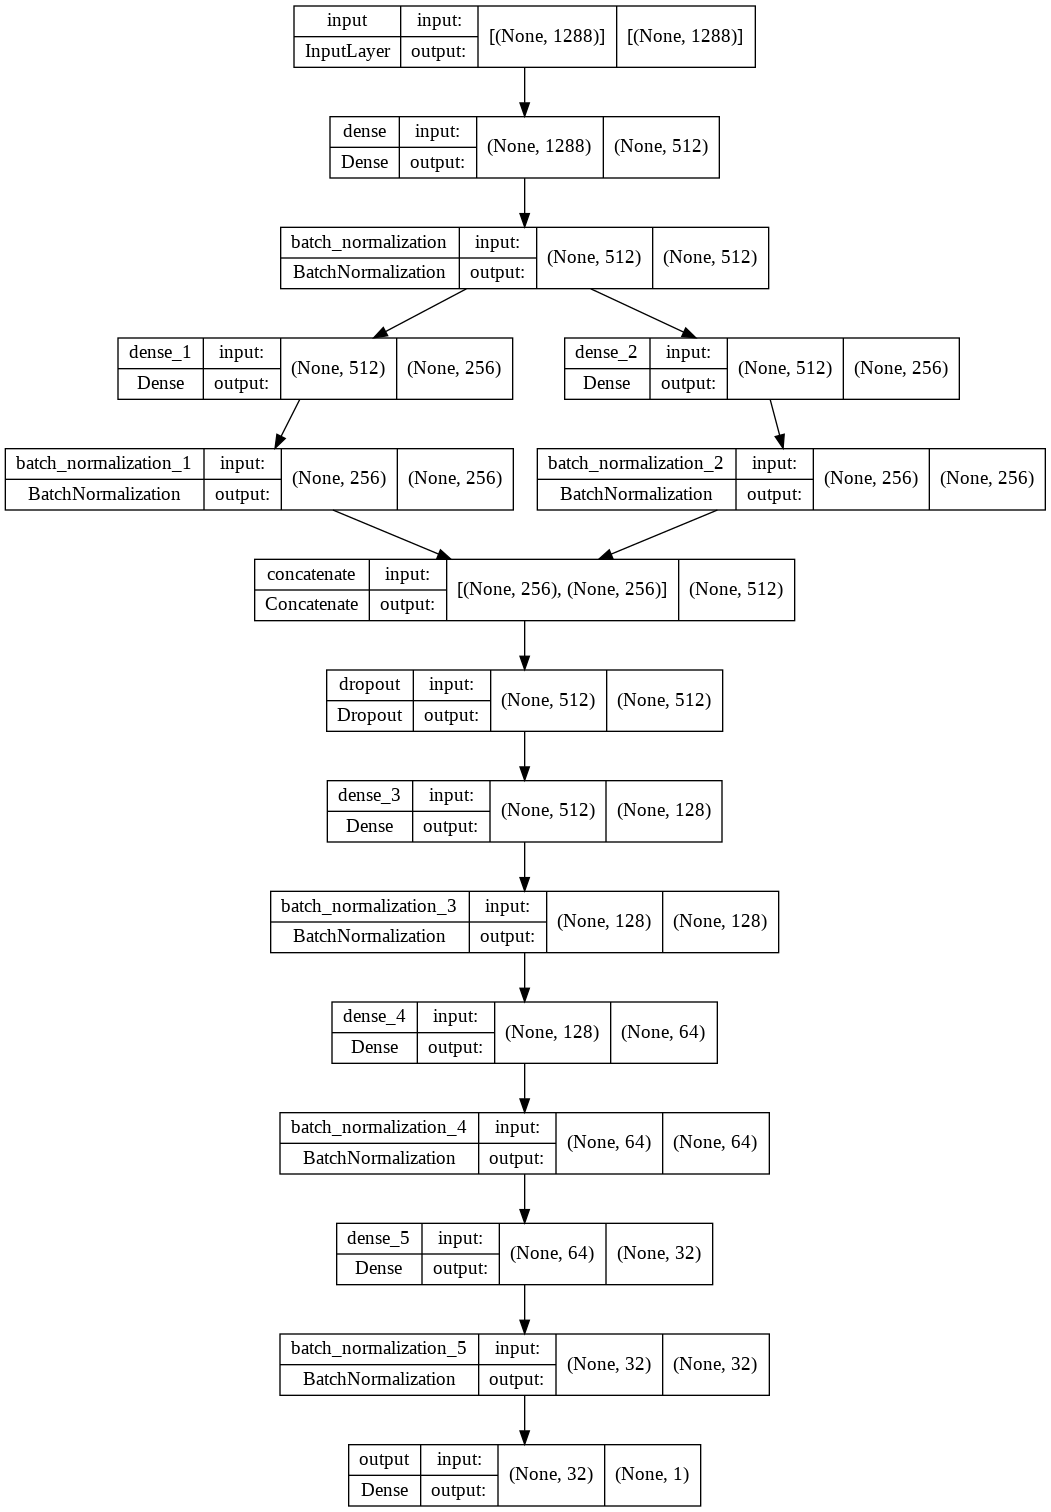

In [43]:
plot_model(
    model, 
    to_file='Super_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [56]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

path = Path("/content/drive/My Drive/Skillbox/model_inno/CNN/Checkpoints")
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "best_checkpoint_{val_f1:.4f}.hdf5"  
cpt_path =str(path / cpt_filename)


loss = f1_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_f1', verbose=1, save_best_only=True, mode='max')  


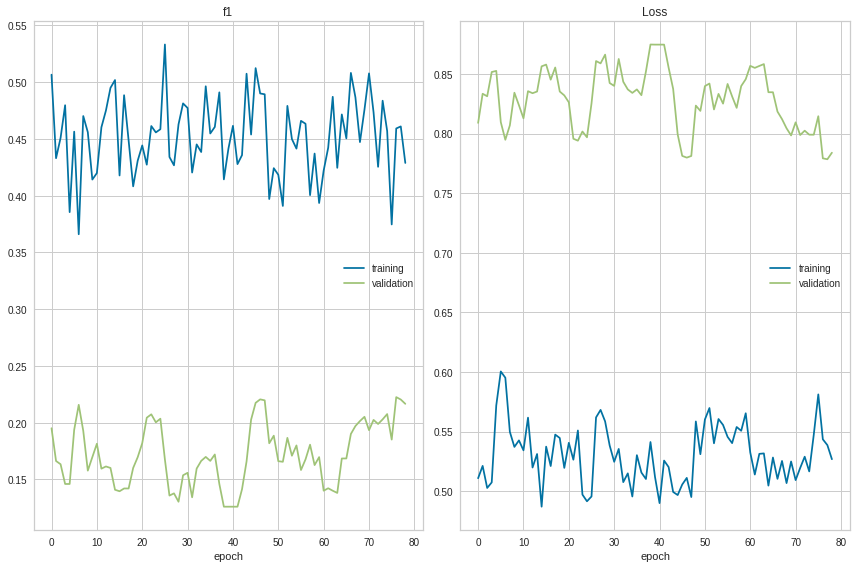

f1
	training         	 (min:    0.366, max:    0.533, cur:    0.429)
	validation       	 (min:    0.126, max:    0.223, cur:    0.217)
Loss
	training         	 (min:    0.487, max:    0.601, cur:    0.527)
	validation       	 (min:    0.779, max:    0.875, cur:    0.784)

Epoch 79: val_f1 did not improve from 0.26211
9/9 [==============================] - 1s 128ms/step - loss: 0.5269 - f1: 0.4289 - val_loss: 0.7840 - val_f1: 0.2167
Epoch 80/300


KeyboardInterrupt: ignored

In [59]:
for _ in range(500):
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=optimizer, 
            loss=loss, 
            metrics=[f1])
  
  lr = ReduceLROnPlateau(monitor="val_f1", factor=0.6, 
                              patience=3, verbose=1)

  es = EarlyStopping(monitor="val_f1", patience=20, 
                          verbose=1, mode="max", 
                          restore_best_weights=True)      

  model.fit(X_train, y_train, 
                validation_data=(X_test, y_test), 
                epochs=50,
                verbose=1,
                batch_size=BATCH_SIZE, 
                callbacks=[lr, PlotLossesCallback(), checkpoint, es])

In [ ]:
model.load_weights("/content/drive/My Drive/Skillbox/model_inno/CNN/Temp/best_checkpoint_val_046.hdf5")
y_pred_nr = model.predict(X_test)
y_pred_nr = K.round(K.clip(y_pred_nr, 0, 1)).numpy().ravel().astype('int')
print(f1_score(y_test, y_pred_nr))

0.44444444444444436


In [ ]:
clf_report = classification_report(y_test, y_pred_nr,digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9714    0.9955    0.9833      1333
           1     0.7500    0.3158    0.4444        57

    accuracy                         0.9676      1390
   macro avg     0.8607    0.6556    0.7139      1390
weighted avg     0.9624    0.9676    0.9612      1390



In [ ]:
y_pred_nr = model.predict(test.drop('Smiles', axis=1))
y_pred_nr = K.round(K.clip(y_pred_nr, 0, 1)).numpy().ravel().astype('int')

pred_tf = test[['Smiles']].copy(deep=True)
pred_tf['Active'] = y_pred_nr

In [ ]:
!pip install xgboost

In [ ]:


# sm = SMOTETomek(random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

paramsXGB = {#'max_depth': 8,
             'learning_rate': 0.01, 
             #'min_child_weight': 8, 
             #'gamma': 0.018329940112279165, 
             #'alpha': 0.00019394894279195157, 
             #'lambda': 0.06161761858777205, 
             #'colsample_bytree': 0.6721122683333417, 
             #'subsample': 0.6155733760919804,
             'n_estimators': 3000,
             #'tree_method': 'gpu_hist',
             #'booster': 'gbtree',
             'random_state': 228,
             #'use_label_encoder': False,
             #'objective': 'binary:logistic',
             #'predictor': 'gpu_predictor'
             }

def xgb_f1(y, t, threshold=0.05):
    t = t.get_label()
    y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    return 'f1',f1_score(t,y_bin)

xgb = XGBClassifier(**paramsXGB)
xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 3, early_stopping_rounds = 30, eval_metric=xgb_f1)



[0]	validation_0-error:0.041007	validation_0-f1:0.078784
Multiple eval metrics have been passed: 'validation_0-f1' will be used for early stopping.

Will train until validation_0-f1 hasn't improved in 30 rounds.
[3]	validation_0-error:0.041727	validation_0-f1:0.078784
[6]	validation_0-error:0.041727	validation_0-f1:0.078784
[9]	validation_0-error:0.041727	validation_0-f1:0.078784
[12]	validation_0-error:0.041727	validation_0-f1:0.078784
[15]	validation_0-error:0.041727	validation_0-f1:0.078784
[18]	validation_0-error:0.041727	validation_0-f1:0.078784
[21]	validation_0-error:0.041727	validation_0-f1:0.078784
[24]	validation_0-error:0.041007	validation_0-f1:0.078784
[27]	validation_0-error:0.041007	validation_0-f1:0.078784
[30]	validation_0-error:0.041007	validation_0-f1:0.078784
Stopping. Best iteration:
[0]	validation_0-error:0.041007	validation_0-f1:0.078784



XGBClassifier(learning_rate=0.01, n_estimators=3000, random_state=228)

In [ ]:
y_pred_xgb = (xgb.predict_proba(X_test)[:,1] > 0.499).astype(int)
clf_report = classification_report(y_test, y_pred_xgb, digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9595    0.9955    0.9772      1333
           1     0.1429    0.0175    0.0312        57

    accuracy                         0.9554      1390
   macro avg     0.5512    0.5065    0.5042      1390
weighted avg     0.9260    0.9554    0.9384      1390



In [ ]:
y_pred_xgb = (xgb.predict_proba(test.drop('Smiles', axis=1))[:,1] > 0.499).astype(int)
pred_xgb = test[['Smiles']].copy(deep=True)
pred_xgb['Active'] = y_pred_xgb

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from pytorch_tabnet.metrics import Metric

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=0.01),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

tab = TabNetClassifier(**tabnet_params, verbose=3,seed=42, device_name=DEVICE)
save_history = []
for i in range(1):
    tab.fit(
        X_train=X_train.values, y_train=y_train,
        eval_set=[(X_train.values, y_train), (X_test.values, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['balanced_accuracy'],
        max_epochs=50, patience=20,
        batch_size=256, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,        
    )
    save_history.append(tab.history["valid_balanced_accuracy"])


Using cuda
Device used : cuda
epoch 0  | loss: 0.78091 | train_balanced_accuracy: 0.54033 | valid_balanced_accuracy: 0.50424 |  0:00:02s
epoch 3  | loss: 0.49729 | train_balanced_accuracy: 0.67712 | valid_balanced_accuracy: 0.56384 |  0:00:11s
epoch 6  | loss: 0.21314 | train_balanced_accuracy: 0.8525  | valid_balanced_accuracy: 0.57653 |  0:00:20s
epoch 9  | loss: 0.09176 | train_balanced_accuracy: 0.93752 | valid_balanced_accuracy: 0.55396 |  0:00:29s
epoch 12 | loss: 0.05766 | train_balanced_accuracy: 0.97361 | valid_balanced_accuracy: 0.57788 |  0:00:38s
epoch 15 | loss: 0.04311 | train_balanced_accuracy: 0.99154 | valid_balanced_accuracy: 0.57211 |  0:00:47s
epoch 18 | loss: 0.02867 | train_balanced_accuracy: 0.99502 | valid_balanced_accuracy: 0.56357 |  0:00:55s
epoch 21 | loss: 0.0294  | train_balanced_accuracy: 0.99539 | valid_balanced_accuracy: 0.5874  |  0:01:04s
epoch 24 | loss: 0.03421 | train_balanced_accuracy: 0.99515 | valid_balanced_accuracy: 0.59566 |  0:01:13s
epoch 2

In [ ]:
y_pred_tab = tab.predict(X_test.values)
clf_report = classification_report(y_test, y_pred_tab, digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9669    0.9632    0.9651      1333
           1     0.2097    0.2281    0.2185        57

    accuracy                         0.9331      1390
   macro avg     0.5883    0.5957    0.5918      1390
weighted avg     0.9358    0.9331    0.9344      1390



In [ ]:
y_pred_tab = tab.predict(test.drop('Smiles', axis=1).values)
pred_tab = test[['Smiles']].copy(deep=True)
pred_tab['Active'] = y_pred_tab

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=200, verbose=1, use_best_model=True)
cat.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred_cat = cat.predict(X_test)
clf_report = classification_report(y_test, y_pred_cat, digits = 4)
print(clf_report)


Learning rate set to 0.106777
0:	learn: 0.6077716	test: 0.6320726	best: 0.6320726 (0)	total: 194ms	remaining: 38.6s
1:	learn: 0.5551955	test: 0.5785684	best: 0.5785684 (1)	total: 354ms	remaining: 35.1s
2:	learn: 0.5052344	test: 0.5318792	best: 0.5318792 (2)	total: 506ms	remaining: 33.2s
3:	learn: 0.4644866	test: 0.4960242	best: 0.4960242 (3)	total: 653ms	remaining: 32s
4:	learn: 0.4287595	test: 0.4684835	best: 0.4684835 (4)	total: 803ms	remaining: 31.3s
5:	learn: 0.3906394	test: 0.4438220	best: 0.4438220 (5)	total: 959ms	remaining: 31s
6:	learn: 0.3590509	test: 0.4203893	best: 0.4203893 (6)	total: 1.11s	remaining: 30.7s
7:	learn: 0.3382888	test: 0.4028329	best: 0.4028329 (7)	total: 1.27s	remaining: 30.6s
8:	learn: 0.3168177	test: 0.3811204	best: 0.3811204 (8)	total: 1.44s	remaining: 30.6s
9:	learn: 0.3005733	test: 0.3633794	best: 0.3633794 (9)	total: 1.6s	remaining: 30.4s
10:	learn: 0.2780682	test: 0.3447185	best: 0.3447185 (10)	total: 1.74s	remaining: 30s
11:	learn: 0.2583009	test: 0.

In [ ]:
y_pred_cat = cat.predict(test.drop('Smiles', axis=1).values)
pred_cat = test[['Smiles']].copy(deep=True)
pred_cat['Active'] = y_pred_cat

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
x_cl_train = pca.fit_transform(X_train)
print(sum(pca.explained_variance_ratio_))

0.9384192765113056


In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_cl_train, y_train)
y_pred_tree = tree.predict(pca.transform(X_test))
clf_report = classification_report(y_test, y_pred_tree, digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9671    0.8590    0.9098      1333
           1     0.0874    0.3158    0.1369        57

    accuracy                         0.8367      1390
   macro avg     0.5272    0.5874    0.5233      1390
weighted avg     0.9310    0.8367    0.8781      1390



In [ ]:
y_pred_tree = tree.predict(pca.transform(test.drop('Smiles', axis=1).values))
pred_tree = test[['Smiles']].copy(deep=True)
pred_tree['Active'] = y_pred_tree

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.00599484, random_state=0, max_iter=3000).fit(pca.transform(X_train), y_train)
y_pred_log = log_reg.predict(pca.transform(X_test))
clf_report = classification_report(y_test, y_pred_log, digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9756    0.5409    0.6959      1333
           1     0.0599    0.6842    0.1102        57

    accuracy                         0.5468      1390
   macro avg     0.5178    0.6125    0.4031      1390
weighted avg     0.9381    0.5468    0.6719      1390



In [ ]:
y_pred_log = log_reg.predict(pca.transform(test.drop('Smiles', axis=1).values))
pred_log = test[['Smiles']].copy(deep=True)
pred_log['Active'] = y_pred_log

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from scipy import stats
blend_ss = pred_torch.copy()
pred_best = pd.read_csv('./drive/MyDrive/submission_1.csv')
print(pred_best['Active'].sum())

blend_preds = []
for preds in [pred_torch, pred_tf, pred_xgb, pred_tab, pred_cat, pred_tree, pred_log, pred_best]:
    blend_preds.append(preds['Active'])
    
blend_ss = pred_torch.copy()
blend_ss['Active'] = stats.mode(np.column_stack(blend_preds), axis=1)[0]

77


In [ ]:
blend_ss['Active'] = y_pred
blend_ss[['Smiles', 'Active']].to_csv('submission.csv', index=False)
